In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RepeatedKFold,StratifiedKFold,GridSearchCV,cross_val_score

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")


# definzioni funzioni varie
def timeserieFeatureExtractor(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['dayofyear'] = timeseries.index.dayofyear
    timeseries['dayofmonth'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
    timeseries['daysinmonth'] = timeseries.index.daysinmonth
    timeseries['month'] = timeseries.index.month
    timeseries['year'] = timeseries.index.year
    timeseries['weekend'] = np.where(timeseries.index.dayofweek > 4, 1, 0)
    timeseries.fillna(0,inplace=True)
    return 

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

In [2]:
df = pd.read_csv('dataframe.csv',parse_dates=['date'],index_col=['date'])
df

,perc_oggi,ospedalizzati_oggi,Temperatura_media,Umidità_media
date,,,,
2020-09-07,1.460000,268.0,20.981416,79.769909
2020-09-08,1.432857,275.0,21.696111,71.287302
2020-09-09,1.380000,279.0,22.247918,70.887285
2020-09-10,1.350000,286.0,22.795952,73.563690
2020-09-11,1.378571,273.0,23.065238,72.722619
...,...,...,...,...
2022-08-30,14.430000,680.0,24.902930,73.119505
2022-08-31,14.257143,655.0,23.088153,76.984631
2022-09-01,14.020000,627.0,23.094048,70.111264


In [3]:
data = df.copy()

lag_days = 7
for j in range(1,lag_days):
    data[f'ospedalizzati_oggi {j}'] = data['ospedalizzati_oggi'].shift(j).dropna()
for j in range(1,lag_days):
    data[f'perc_oggi {j}'] = data['perc_oggi'].shift(j).dropna()

# predicion set
data_for_predticion = data.drop('ospedalizzati_oggi',axis=1)[data.index >= data.index[-7]]
data_for_predticion.reset_index(drop=True,inplace=True)
data_for_predticion['date'] = pd.date_range(start=data.index[-1]+timedelta(days=1),periods=len(data_for_predticion))
data_for_predticion.set_index('date',inplace=True)
timeserieFeatureExtractor(data_for_predticion)

# training set
training_data = data.copy()
shift_list = list(data.drop(['ospedalizzati_oggi'],axis=1).columns)
training_data[shift_list] = training_data[shift_list].shift(7).fillna(method='bfill')
timeserieFeatureExtractor(training_data)

In [4]:
# calculate train, test and validation length using train_test_split
X = training_data.drop(columns='ospedalizzati_oggi')
y = training_data['ospedalizzati_oggi']

X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.20, random_state=42)



[0]	validation_0-rmse:2733.63820	validation_1-rmse:2810.82003
[20]	validation_0-rmse:406.35937	validation_1-rmse:469.70069
[40]	validation_0-rmse:76.55698	validation_1-rmse:211.80890
[60]	validation_0-rmse:23.96607	validation_1-rmse:183.37149
[80]	validation_0-rmse:13.43166	validation_1-rmse:178.92788
[100]	validation_0-rmse:8.64227	validation_1-rmse:177.78042
[120]	validation_0-rmse:6.21165	validation_1-rmse:177.37795
[140]	validation_0-rmse:4.58656	validation_1-rmse:177.25009
[159]	validation_0-rmse:3.58150	validation_1-rmse:177.27708


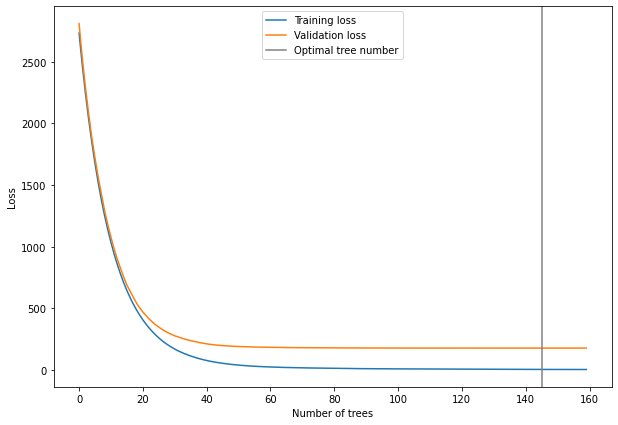

best trees numb: 145


In [5]:
# -> xgboost regressor
# early stopping rounds for xgboost
model = XGBRegressor(n_estimators=300, 
                         max_depth=6, 
                         learning_rate=0.1,
                         seed = 42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          early_stopping_rounds=15,
          verbose=20) 

# plot n° trees (asse x) vs loss function, rmse (asse y)
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()


best_numb_trees = model.best_ntree_limit
print(f'best trees numb: {best_numb_trees}')

Error on validation data
Mean Squared Error: 18116.8246
Root Mean Sqarred Error: 134.5988
Mean Absolute Error: 82.9615
Mean Absolute Percentage Error: 4.8941


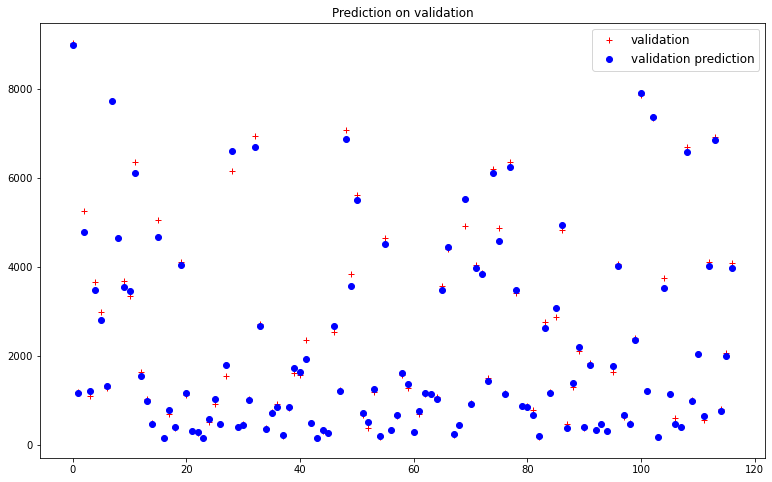

Error on test data
Mean Squared Error: 29613.3162
Root Mean Sqarred Error: 172.0852
Mean Absolute Error: 87.7877
Mean Absolute Percentage Error: 3.87


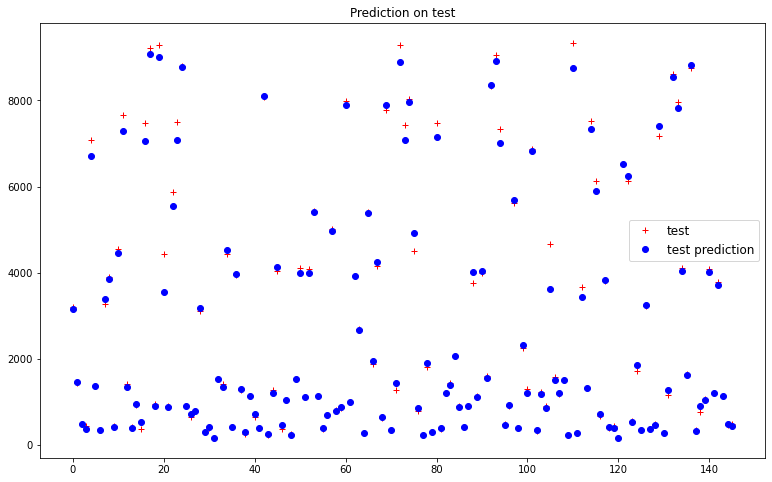


MSE cross validation: 34441.3059
RMSE cross validation: 185.5837


In [6]:
# -> fitting the model
model = XGBRegressor(
#                      booster = 'gbtree',
#                      eval_metric = 'rmse',
#                      objective = 'reg:squarederror',
                     eta = 0.1,
                     min_child_weight = 0.9,
                     max_depth = 5,
                     max_delta_step = 0,
                     subsample = 0.7,
                     colsample_bytree = 0.5,
                     colsample_bylevel = 1,
                     gamma = 1,
                     reg_lambda = 0.4,
                     reg_alpha = 0,
                     n_estimators = best_numb_trees,
                     seed = 42)
model.fit(X_train, y_train)



# prediction of validation
y_pred_val = model.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data')
calcError(y_val,y_pred_val)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,'r+',label='validation')
plt.plot(y_pred_val,'bo',label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation')
plt.show()



# prediction of test 
y_pred_test = model.predict(X_test)

# error on test on the first prediction 
print('Error on test data')
calcError(y_test,y_pred_test)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,'r+',label='test')
plt.plot(y_pred_test,'bo',label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test')
plt.show()

# error with cross validation on only training set
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=cv, 
                         n_jobs=-1)

print(f'\nMSE cross validation: {round(abs(scores).mean(),4)}')
print(f'RMSE cross validation: {round(sqrt(abs(scores).mean()),4)}')



In [7]:
# -> tuning xgb parameters
# GridSeadchCV 
parameters = {'max_depth':[4,5,6,7],
              'eta':[0.09,0.1,0.11]}

clf = GridSearchCV(model, 
                   parameters,
                   scoring = 'neg_mean_squared_error',
                   cv = 5,
                   verbose = False)

# fitting on total training set (train + val)                              
clf.fit(X_train_total, y_train_total,verbose = False)

best_estimator = clf.best_estimator_

Error on test data after tuning
Mean Squared Error: 24046.8954
Root Mean Sqarred Error: 155.0706
Mean Absolute Error: 86.8563
Mean Absolute Percentage Error: 3.9904


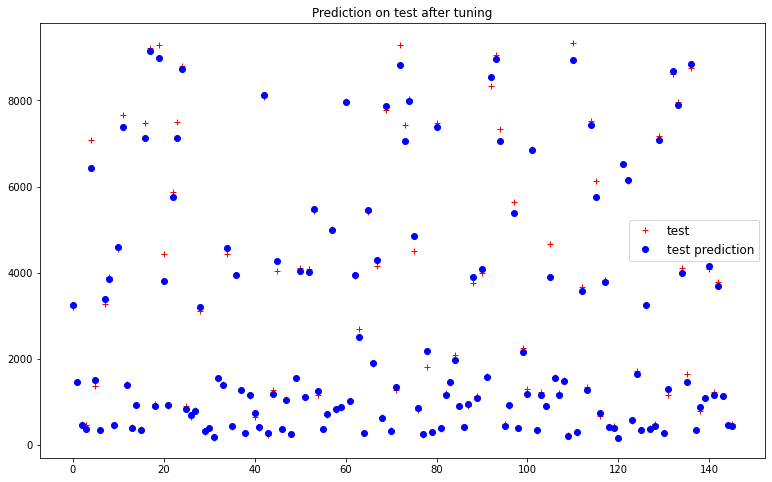


MSE cross validation after tuning: 24634.3136
RMSE cross validation after tuning: 156.9532


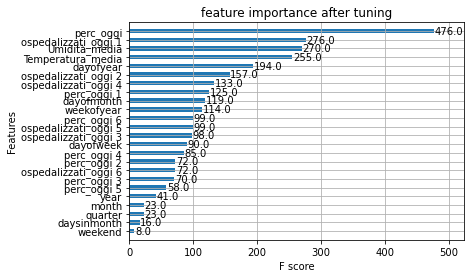

In [8]:
# -> prediction of test after tuning
tune_y_test_pred = best_estimator.predict(X_test)

# error on test on the first prediction 
print('Error on test data after tuning')
calcError(y_test,tune_y_test_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,'r+',label='test')
plt.plot(tune_y_test_pred,'bo',label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test after tuning')
plt.show()
                              
# error with cross validation on entire training set
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(best_estimator, 
                         X_train_total, 
                         y_train_total, 
                         scoring='neg_mean_squared_error', 
                         cv=cv, 
                         n_jobs=-1)

print(f'\nMSE cross validation after tuning: {round(abs(scores).mean(),4)}')
print(f'RMSE cross validation after tuning: {round(sqrt(abs(scores).mean()),4)}')

# feature importance of tuning xgboost 
plot_importance(model,height=0.5)
plt.title('feature importance after tuning')
plt.show()

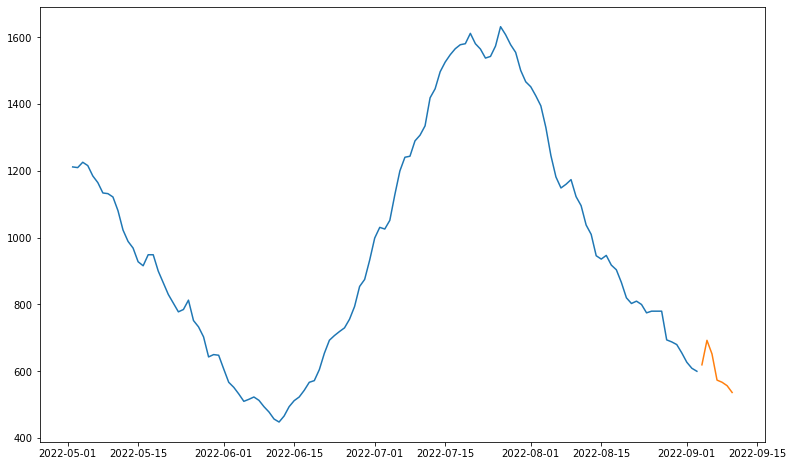

In [9]:
new_prediction = best_estimator.predict(data_for_predticion)
new_prediction = pd.DataFrame(data=new_prediction,index=data_for_predticion.index)
new_prediction.rename(columns = {0:'ospedalizzati_7_days_in_future'},inplace=True)

plt.figure(figsize=(13,8))
plt.plot(data.ospedalizzati_oggi[data.index > '2022-05-01'],label='original_data')
plt.plot(new_prediction,label='predicted_data')

In [10]:
# Paragone tra ospedalizzati tra 7 giorni (7D) e andamento rapporto positivi/tamponi (perc_oggi - pos/tamp) 
# -> dovrebbero avere lo stesso andamento

# creazione nuovo df
new_pred_2 = new_prediction.reset_index(drop=True)
new_perc = data.perc_oggi[data.index >= data.index[-7]].reset_index(drop=True)
new_pred_df = pd.DataFrame(data=new_pred_2)
new_pred_df['old_perc'] = new_perc

# calcoli utili per variazione percentuale giornaliera degli ospedalizzati e pos/tamp
down_perc = new_pred_df.old_perc.shift(1).fillna(method='bfill').values
up_perc = new_pred_df.old_perc.values

down_osp = new_pred_df.ospedalizzati_7_days_in_future.shift(1).fillna(method='bfill').values
up_osp = new_pred_df.ospedalizzati_7_days_in_future.values

change_perc = up_perc/down_perc*100-100
change_osp = up_osp/down_osp*100-100

# direzione degli ospedalizzati_7D e pos/tamp oggi 
what_perc = []
for i in change_perc:
    if i > 0:
        idk = 'up'
    elif i == 0:
        idk = '-'
    else:
        idk = 'down'
    what_perc.append(idk)   
    
what_osp = []
for i in change_osp:
    if i > 0:
        idk = 'up'
    elif i == 0:
        idk = '-'
    else:
        idk = 'down'
    what_osp.append(idk) 
    
# colonne nel nuovo df   
new_pred_df['osp_direction'] = what_osp
new_pred_df['perc_direction'] = what_perc

new_pred_df

,ospedalizzati_7_days_in_future,old_perc,osp_direction,perc_direction
0,619.355103,14.705714,-,-
1,692.692078,14.742857,up,up
2,651.906494,14.430000,down,down
3,573.554871,14.257143,down,down
4,567.129211,14.020000,down,down
5,556.869934,13.755714,down,down
6,536.540527,13.324286,down,down


In [11]:
new_prediction

,ospedalizzati_7_days_in_future
date,
2022-09-04,619.355103
2022-09-05,692.692078
2022-09-06,651.906494
2022-09-07,573.554871
2022-09-08,567.129211
2022-09-09,556.869934
2022-09-10,536.540527


In [12]:
with open("results.txt","w") as res:
    res.write('XGBoost Regressor\n')
    for i in range(len(new_prediction)):
        date = str(new_prediction.index[i])
        value = str(new_prediction.ospedalizzati_7_days_in_future.values[i])
        res.write(date+' - '+value+'\n')
    res.write('\n\n')